## Zaawansowane Metody Inteligencji Obliczeniowej
# Zadanie domowe 2
### Prowadzący: Michał Kempka, Marek Wydmuch
### Autor: Dariusz Max Adamski, nr indeksu 136674, godzina 16:50

In [1]:
import gym
import numpy as np
import random
import math

## Wprowadzenie

Zadania będą polegały na implementacji różnych wariantów algorytmu Q-Learning dla dwóch środowisk z biblioteki OpenAI Gym (https://gym.openai.com): `CartPole` i `LunarLander`.

#### Uwaga: Możesz dowolnie modyfikować elementy tego notebooka (wstawiać komórki i zmieniać kod) o ile nie napisano gdzieś inaczej.

### Interface agenta

Wszystkie implementacje będą w oparciu o klasę `Agent` przedstawioną poniżej. Powinna ona implementować dwie metody: 1) `process_transition`, która będzie wykorzystywana tylko podczas uczenia by przekazać do agenta krotkę zawierającą obserwacje, podjętą akcję, nagrodę i następujący stan oraz informację czy jest on terminalny. 2) `get_action` która na podstawie obserwacji zwraca akcję, dodatkowy argument informuję Agenta czy jest w aktualnie podczas uczenia czy ewaluacji.

Poniżej znajdziiesz też funkcję `run_agent_in_env`, która korzysta z opisanego wyżej obiektu agenta w celu jego uczenia lub ewaluacji (podobną będziemy używać my podczas sprawdzania wszych rozwiązań). Możecie ją modyfikować jeśli widzicie taką potrzebę. Dopisaliśmy do tej funkcji rysowanie wykresu nagród z minionych epizodów, który uaktualnia się co ich zadaną liczbę.

In [2]:
class Agent:
    def __init__(self, env):
        self.observation_space = env.observation_space
        self.action_space = env.action_space
    
    def process_transition(self, observation, action, reward, next_observation, done):
        raise NotImplementedError()
        
    def get_action(self, observation, learning):
        raise NotImplementedError()

In [3]:
import matplotlib.pylab as plt
from IPython import display
%matplotlib inline

def plot_rewards(rewards, eps, roll):
    fig, ax = plt.subplots()
    ax.margins(x=0)
    ax.plot(rewards)
    ax.plot(pd.Series(rewards).rolling(roll).mean())
    ax2 = ax.twinx()
    ax2.plot(eps, label='epsilon', color='k')
    #ax2.plot(alpha, label='alpha', color='b')
    ax2.legend(loc='lower left')
    ax2.grid(False)
    ax2.set_ylim(0, 1)
    display.display(plt.gcf())
    display.clear_output(wait=True)
    
def run_agent_in_env(env, agent, episodes, learning=False, plot=False, plot_interval=1000, target=None, target_window=None):
    rewards = []
    eps = []
    roll = target_window or 50
    for episode in range(episodes):
        observation = env.reset()
        total_reward = 0
        done = False
        while not done :
            # Zapytajmy agenta o akcje dla aktualnego stanu
            action = agent.get_action(observation, learning)
            
            # Wykonajmy akcje
            next_observation, reward, done, _ = env.step(action)
            total_reward += reward
            
            # Jeśli się uczymy, przekażmy przejście do agenta
            if learning:
                agent.process_transition(observation, action, reward, next_observation, done)
            
            observation = next_observation
        rewards.append(total_reward)
        eps.append(agent.ε)
        
        # Wyświetl na wykresie nagrody otrzymane po kolei w epizodach
        if plot and episode % plot_interval == 0:
            plot_rewards(rewards, eps, roll)
            
        if plot and  target is not None and len(rewards) > target_window and np.mean(rewards[-target_window:]) > target:
            print('early stopping...')
            plot_rewards(rewards, eps, roll)
            break
    return rewards    

def test_agent(env, agent, epochs, render=False):
    import seaborn as sns
    render = render or epochs <= 5
    scores = []
    for _ in range(epochs):
        observation = env.reset()
        score = 0
        for _ in range(500):
            if render: env.render()
            action = agent.get_action(observation, learning=False)
            observation, reward, done, _ = env.step(action)
            score += reward
            if done: break
        scores.append(score)
        if render: env.close()
    plt.subplots()
    plt.hist(scores, label='scores'); plt.xlabel('score')
    plt.axvline(np.mean(scores), color='k', label='mean')
    plt.legend(loc='upper right')
    print('mean score', np.mean(scores))

## Zad 1 - Tabularyczny Q-Learning (5pkt)

W komórkach poniżej zaimplementuj prosty tabularyczny Q-Learning dla środowiska `CartPole`, korzystający podczas uczenia się z polityki epsilon-greedy. Ponieważ środowisko `CartPole` ma ciągłą przesteń stanów musisz dokonać odpowiedniej dyskretyzacji stanów. 

Odpowiedź na pytanie: dlaczego po osiągnięciu dobrych wyników obserwujemy spadek jakości? Czy możemy temu jakoś zaradzić?

Uwagi:
- Dobra polityka dająca średni wynik powyżej 200, środowisko ma limit na 500 iteracji. Polityka dająca średni wynik blisko 500 jest więc bardzo dobra.
- Uczenie nie powinno trwać więcej niż 10-15 minut na CPU.
- Postaraj się dobrać i ustawić w `__init__` takie parametry by Twój Agent uczył się i działał jak najlepiej. Są one pod Twoją kontrolą w klasie, więc możesz je odpowiednio kontrolować w trakcie uczenia.


#### Uwaga: nie zmieniaj nazwy klasy `TabularQLearningAgent`, ani pozycyjnych (tych bez wartości domyślnych) argumentów jej metod, możesz dopisywać argumenty z wartościami domyślnymi oraz oczywiście pomocnicze meotdy do klasy. Nie dopisuj do komóreki z klasą innego kodu.

**Odpowiedzi**

Po pewnym czasie możemy zaobserwować spadek średniej nagrody, jeśli nie zmniejszamy wystarczająco szybko learning rate $\alpha$ i współczynnika eksploracji $\varepsilon$, albo nie zatrzymamy uczenia. Stanie się tak, jeśli inna bardziej skomplikowana polityka jest potrzebna do lepszego rozwiązania problemu vs. dotychczasowa prostsza polityka ze średnimi wynikami. Algorytm będzie często (bo duże $\varepsilon$) i gwałtownie (bo duże $\alpha$) zmieniał aktualną politykę, co na pewien czas pogorszy wyniki, a jeśli po pogorszeniu wyników learning rate i/lub eksploracja jeszcze bardziej spadnie, to utkniemy w złej polityce. Alternatywnie przez eksplorację odkryjemy nową, lepszą politykę i wyniki wzrosną.

Widzę dwa rozwiązania:

- Early stopping (łatwe): kończymy uczenie po uzyskaniu satysfakcjonujących wyników (np. średnia nagroda na epizod przez ostatnie n epizodów większa równa od celu)
    - Cel OpenAI dla środowiska cartpole: średnia nagroda z ostatnich 100 epizodów >= 195.0
- Dostrojenie początkowych wartości i wygaszania $\alpha$ i $\varepsilon$ do danego problemu (nieprzewidywalne i irytujące): w problemie cartpole zauważyłem, że term zmniejszający oba parametry (decay) powinien być podobny - inaczej uczenie jest niestabilne. Oba parametry powinny dążyć do 0. 

In [152]:
class TabularQLearningAgent(Agent):
    def __init__(self, env, γ=1, α=0.3, ε=0.7, α_decay=0.999, ε_decay=0.999, α_min=0, ε_min=0):
        super().__init__(env)
        self.γ = γ
        self.ε, self.ε_decay, self.ε_min = ε, ε_decay, ε_min
        self.α, self.α_decay, self.α_min = α, α_decay, α_min
        
        self.buckets = np.array([10, 10, 20, 20])
        self.upper_bounds = np.array([4.8, 2, 0.4, 2])
        self.lower_bounds = -self.upper_bounds
        
        dims = tuple(self.buckets.astype(int))
        np.random.seed(None)
        self.Q = np.random.random_sample((*dims, env.action_space.n))
    
    def process_transition(self, observation, action, reward, next_observation, done):
        a, r, s, s_next = action, reward, self.discrete(observation), self.discrete(next_observation)
        if done:
            self.Q[s_next] = 0
            self.ε = max(self.ε_min, self.ε * self.ε_decay)
            self.α = max(self.α_min, self.α * self.α_decay)
        self.Q[s][a] += self.α * (r + self.γ*np.max(self.Q[s_next]) - self.Q[s][a])
        
    def get_action(self, observation, learning):
        if learning and np.random.rand() < self.ε:
            return np.random.randint(self.action_space.n)
        s = self.discrete(observation)
        a = np.argmax(self.Q[s])
        return a
        
    def discrete(self, s):
        return tuple(self.bucketize(s, self.lower_bounds, self.upper_bounds, self.buckets))
    
    @staticmethod
    def bucketize(x, lb, ub, n):
        x = (np.clip(x / (1 - 1/n), lb, ub) - lb)/(ub - lb)
        return np.round((n-1)*x).astype(int)

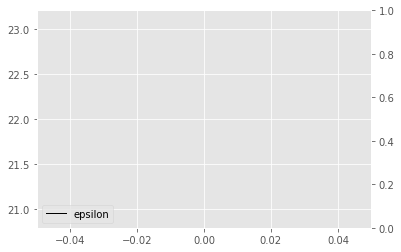

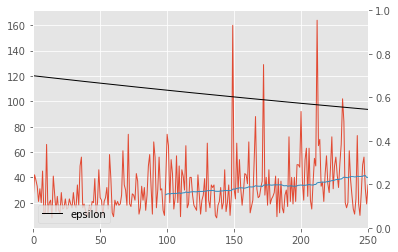

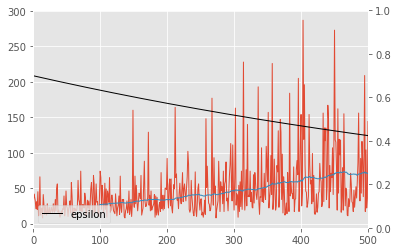

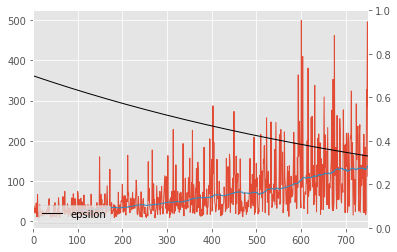

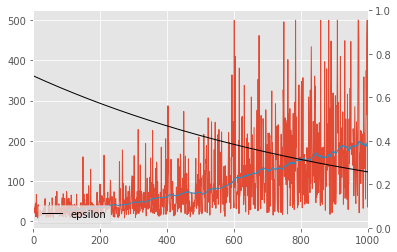

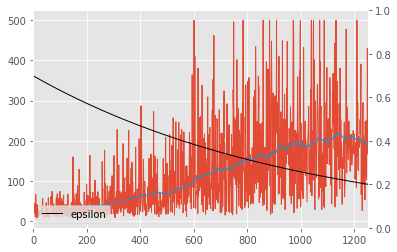

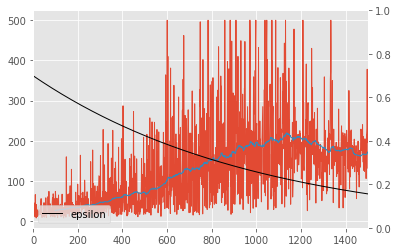

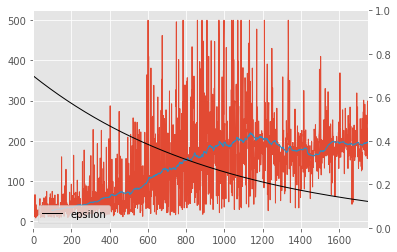

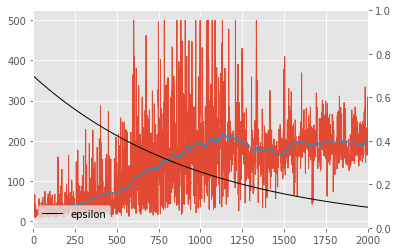

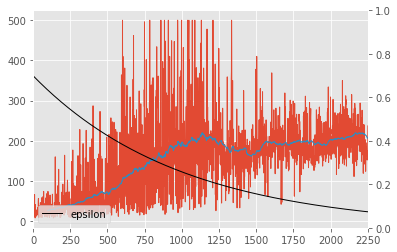

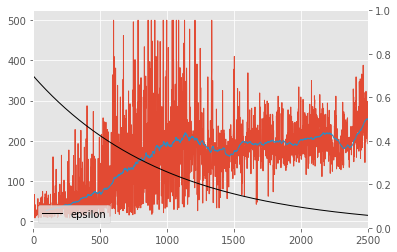

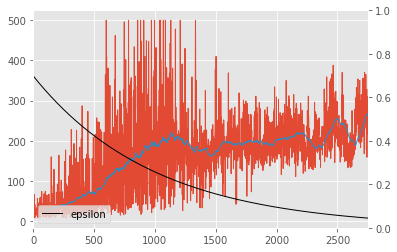

In [153]:
# Uczenie/testowania agenta
env = gym.make("CartPole-v1")
agent = TabularQLearningAgent(env)
_ = run_agent_in_env(env, agent, 3000, learning=True, plot=True, target=400, target_window=100, plot_interval=250)

mean score 284.93


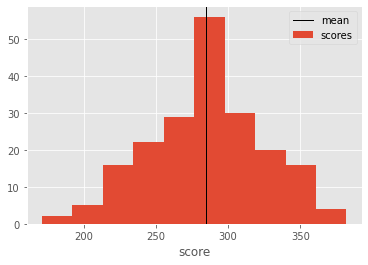

In [154]:
test_agent(env, agent, epochs=200)

## Zad 2 - Q-Learning z aproksymacją (25pkt)

W komórkach poniżej zaimplementuj Q-Learning z aproksymacją dla środowiska `LunarLander`, korzystający podczas uczenia się z polityki epsilon-greedy, a jako aproksymatora użyj prostej sieć neuronową zaimplementowanej z wykorzystaniem biblioteki PyTroch. Zaimplementuj następujące ulepszenia algorytmu Q-Learning:
- replay memory i uczenia batchowe zamiast uczenia online OK
- network freezing OK
- double q-learning OK

Porównaj ze sobą różne warianty algorytmu (nie duplikuj swojej implementacji, dodaj odpowiednie argumenty w konstruktorze, które będą włączać/wyłączać odpowiednie rozszerzenie), zademonstruj oczywiście swoje wyniki pozostawiając odpowiedni output z komórek oraz je skomentuj. Opisz również jak dokonałeś doboru parametrów Twojego modelu.

Uwagi:
- Dobra polityka powina mieć średnią bliską 100, bardzo dobra bliską 200.
- Uczenie nie powinno trwać więcej niż 10-15 minut (przy dobrze zaimplementowanych rozszerzeniach powinno być dużo szybsze) na CPU (możesz oczywiście użyć GPU jeśli masz taką możliwość, ale zadbaj by domyślnie Twoja implemnetacja działałą na CPU).
- Postaraj się dobrać i ustawić w `__init__` takie parametry (w tym architektuę sieci neuronowej) by Twój Agent uczył się i działał jak najlepiej. Są one pod Twoją kontrolą w klasie, więc możesz je odpowiednio kontrolować w trakcie uczenia.
- Założona architektura nie jest potrzebna do rozwiązania tego problemu, zacznij od prostego aproksymatora (np. liniowego albo sieci z dwoma warstwami) i stopniowo zwiększaj jego złożoność.
- Możesz najpierw testować swoją implementację na środowisku `CartPole`, jest to prostszy problem i z dobrymi parametrami nawet prosta wersja Q-Learningu z aproksymacją powinna się go uczyć w nie więcej niż 2-3 minuty na CPU.

#### Uwaga: nie zmieniaj nazwy klasy `NeuralQLearningAgent`, ani pozycyjnych (tych bez wartości domyślnych) argumentów jej metod, możesz dopisywać argumenty z wartościami domyślnymi oraz oczywiście pomocnicze meotdy do klasy. Nie dopisuj do komóreki z klasą innego kodu.

## Odpowiedzi

### Dobór parametrów

- Ręczne losowe przeszukiwanie z podanych list (porządny grid search wymagałby zbyt dużego nakładu czasu)
    - Wielkość ukrytej warstwy sieci aproksymującej: `[(32), (64), (128), (256), (32, 32), (64, 64), (128, 128), (256, 256)]`k
        - Małe sieci miały problem ze środowiskiem lunarlander, a większe się zbyt wolno uczyły, więc skończyłem na (128, 128) 
    - wielkość batcha: `[32, 64, 128, 256, 512]`
        - Mniejsze batche powodowały szybsze uczenie na początku, ale za małe cierpiały na niestabilność uczenia online
        - Potencjalne ulepszenie: zwiększanie wielkości batcha z postępem uczenia, żeby było stabilniejsze
    - Learning rate: `[0.01, 0.005, 0.001, 0.0005, 0.0001]`
        - Learning rate >= 0.0005 powodowały niestabilne uczenie. LR = 0.0002 dawał stabilne uczenie i znośną szybkość uczenia.
        - Potencjalne ulepszenie: ustawienie o rząd większy learning rate na początku i zmniejszanie jeśli przez n epizodów nie było polepszenia wyników
    - Częstotliwość synchronizacji sieci: `[5, 10, 20, 30]`
        - Nie zauważyłem dużych zależności pomiędzy tym parametrem i uczeniem, może było odrobinę bardziej stabilne z większymi wartościami. Przy wybranym małym learning rate, wolałem jednak nie spowalniać dodatkowo uczenia.

- Epsilon
    - Początkowo 1 - max eksploracja, po każdym epizodzie wygaszany
- Wygaszanie epsilona
    - Ustawiony na 0.997, tak żeby osiągał minimalną wartość `eps_min` po ok. 500 epizodach
- Minimalny epsilon:
    - Ustawiony na 0.1 - 10% eksploracji to całkiem dużo jak na minimum, ale wg mnie nadal potrzebne, bo sieć nie uczy się tak szybko + stosuję tu early stopping, więc epsilon nie musi zbiegać do 0
- Pojemność pamięci ruchów
    - 1e6 - nie chciałem żeby była zbyt mała, bo ruchy byłyby za szybko zastępowane; z drugiej strony taka wielkość może opóźniać moment kiedy do batcha trafią unikalne ruchy (małe prawdopodobieństwo wybrania), no ale jakoś działało więc zostawiłem...
        
### Końcowa architektura Q

    QModel(
      (model): Sequential(
        (Linear1): Linear(in_features=8, out_features=128, bias=True)
        (Activation1): ReLU()
        (Linear2): Linear(in_features=128, out_features=128, bias=True)
        (Activation2): ReLU()
        (Linear3): Linear(in_features=128, out_features=4, bias=True)
    )


### Kryterium stopu

Średnia nagroda z ostatnich 100 epizodów wynosi 150 lub więcej (wg. OpenAI solved to średnio >= 200)


### Eksperymenty i ocena

Do subiektywnej oceny agentów wykorzystuję histogram nagród z 200 epizodów (w trybie bez uczenia). Histogram jest dołączony pod ostatnią krzywą uczenia dla każdego agenta.


**Agent bez ulpszeń** nie osiąga celu w sensownym czasie. Uczenie było odcięte po 17min (1500ep). Średnia nagroda -9.41. Czegoś ten agent się nauczył, ale to czy wyląduje, czy się rozwali jest jak rzut monetą. Na animacji widać, że za dużo używa silników, za co też dostaje dużo ujemnych punktów. Krzywa uczenia jest bardzo niestabilna, czego się spodziewałem po uczeniu on-line. Po spadku eksploracji do minimum krzywa uczenia tylko oscylowała wokół 0.

**Agent z replay memory** osiąga cel po 27min (ok 800ep - 2x mniej niż bez ulepszeń). Średnia nagroda 166.8. Co ciekawe, histogram wskazuje na bimodalny rozkład nagród (80 i 250) - w pewnym typie sytuacji agent działa miernie, w innym bardzo dobrze - winę zrzucam na losowość w procesie uczenia. Tak jak się spodziewałem, krzywa uczenia jest zdecydowanie bardziej stabilna niż w wariancie bez ulepszeń - średnia krocząca ze 100 epizodów to doskonale obrazuje. Uczenie batchowe unika znacznie różniących się gradientów w kolejnych iteracjach.

**Agent z replay memory i freezing** osiąga cel po 21min (ok 500ep). Średnia nagroda 255. Dodanie sieci `Q_target` i włączenie mrożenia dodatkowo odszumia krzywą uczenia i skraca czas do osiągnięcia celu. Rozkład nagród wygląda bardzo sensownie.

Nie testowałem agentów z kombinacją (replay memory, double-q), bo double-q wymaga dwóch sieci, co włącza parametr freezing, więc jeśli freezing=False, to double_q też musi być=False.

**Agent z replay memory, double-q i freezing** osiąga cel też po ok 21min (ok 500ep). Średnia nagroda 217 trochę gorsza od poprzedniego eksperymentu, ale patrząc na średnią kroczącą (prawie prosta), ten agent ma najbardziej stabilną krzywą uczenia.  Rozkład nagród podobny do poprzedniego agenta, tylko z trochę niższą średnią


### Wnioski

Agentom z ulepszeniami udało się osiągnąć ustawiony cel. Czasy uczenia są większe od sugerowanych 5-15min, chociaż liczba epizodów potrzebnych do osiągnięcia celu spada z każdym ulepszeniem. Automatyczne strojenie parametrów też może przynieść poprawę, bo po sporych staraniach i nie do końca zadowalających wynikach uznałem, że nie jestem zbyt dobrym optymalizatorem hiperparametrów.

In [4]:
import torch as T
import torch.nn.functional as F
from copy import deepcopy

class QModel(T.nn.Module):
    def __init__(self, layers):
        super().__init__()
        model = T.nn.Sequential()
        n = len(layers)
        for i in range(1, n):
            model.add_module(f'Linear{i}', T.nn.Linear(layers[i-1], layers[i]))
            if i < n - 1:
                model.add_module(f'Activation{i}', T.nn.ReLU())
        self.model = model

    def forward(self, x):
        x = x.float()
        return self.model(x)
    
class ReplayMemory:
    def __init__(self, state_width, capacity):
        self.idx, self.len, self.cap = 0, 0, capacity
        self.A, self.R = T.zeros((2, capacity))
        self.S, self.S_next = T.zeros((2, capacity, state_width))
        self.S_term = T.zeros(capacity).bool()
    
    def add(self, a, r, s, s_next, s_term):
        i = self.idx
        self.A[i], self.R[i], self.S[i], self.S_next[i], self.S_term[i] = \
            a, r, s, s_next, s_term
        self.len = min(self.len + 1, self.cap)
        self.idx = (self.idx + 1) % self.cap
    
    def pop(self):
        self.idx -= 1
            
    def batch(self, size):
        m = T.randperm(self.len)[:size]
        return self.A[m], self.R[m], self.S[m], self.S_next[m], self.S_term[m]
    
    def last(self):
        i, j = self.idx - 1, self.idx
        return self.A[i:j], self.R[i:j], self.S[i:j], self.S_next[i:j], self.S_term[i:j]
    
    def __len__(self):
        return self.len

In [5]:
class NeuralQLearningAgent(Agent):
    def __init__(self, env, γ=0.99, ε=1, ε_decay=0.997, ε_min=0.1, η=0.0002, l2=1e-5,
                 hidden=[128, 128], batch_size=64, memory_cap=1_000_000, sync_freq=20,
                 replay_memory=True, freezing=True, double_q=True):
        super().__init__(env)
        self.γ = γ
        self.ε, self.ε_decay, self.ε_min = ε, ε_decay, ε_min
        self.freezing = freezing
        self.double_q = double_q
        self.replay_memory = replay_memory
        self.sync_freq = sync_freq
        self.episode = 0
        self.step = 0
        
        inputs = env.observation_space.shape[0]
        outputs = self.action_space.n
        
        self.batch_size = batch_size
        self.memory = ReplayMemory(inputs, memory_cap)
        
        self.Q_policy = QModel([inputs, *hidden, outputs])
        self.Q_target = deepcopy(self.Q_policy) if freezing else self.Q_policy
        self.optim = T.optim.Adam(self.Q_policy.parameters(), lr=η, weight_decay=l2)
        self.loss = T.nn.MSELoss()
    
    def process_transition(self, observation, action, reward, next_observation, done):
        a, r, s, s_next, s_term = action, reward, T.tensor(observation), T.tensor(next_observation), T.tensor(done).bool()
        
        self.step += 1
        self.memory.add(a, r, s, s_next, s_term)
        if self.replay_memory:
            if len(self.memory) < self.batch_size: return
            a, r, s, s_next, s_term = self.memory.batch(self.batch_size)
        else:
            a, r, s, s_next, s_term = self.memory.last()
            self.memory.pop()
        
        if self.double_q:
            a_next = self.Q_policy(s_next).argmax(1).long().unsqueeze(1)
            q = self.Q_target(s_next).gather(1, a_next).reshape(-1)
        else:
            q = self.Q_target(s_next).max(1).values
            
        y = (r + self.γ*q) * ~s_term
        Y = self.Q_policy(s).gather(1, a.long().unsqueeze(1)).reshape(-1)
        
        loss = self.loss(y, Y)
        self.optim.zero_grad()
        loss.backward()
        self.optim.step()
        
        if done:
            self.ε = max(self.ε_min, self.ε * self.ε_decay)
            self.episode += 1
        
        if self.freezing and self.step % self.sync_freq == 0:
            self.Q_target.load_state_dict(self.Q_policy.state_dict())
        
    def get_action(self, observation, learning):
        if learning and np.random.rand() < self.ε:
            return np.random.randint(self.action_space.n)
        with T.no_grad():
            s = T.tensor(observation).unsqueeze(0)
            a = self.Q_policy(s).argmax()
            return int(a)

In [6]:
from time import time

def train_test_agent(env, agent, episodes=1500, test_episodes=200, target=150, target_window=100):
    t = time()
    rewards = run_agent_in_env(env, agent, episodes, learning=True, plot=True,
                               target=target, target_window=target_window, plot_interval=50)
    t = time() - t
    print('minutes elapsed', t/60)
    test_agent(env, agent, epochs=test_episodes)
    
env = gym.make("LunarLander-v2")

minutes elapsed 17.229982129732768
mean score -9.411529805677837


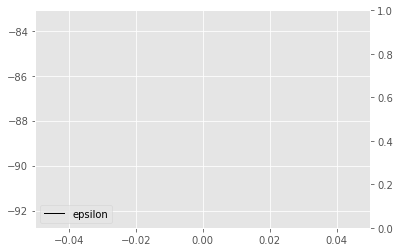

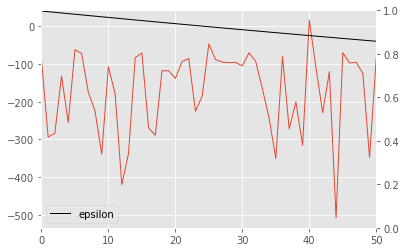

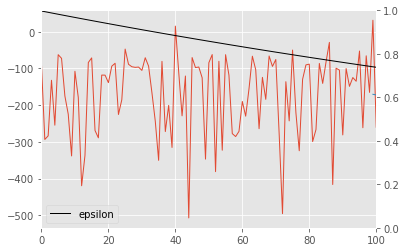

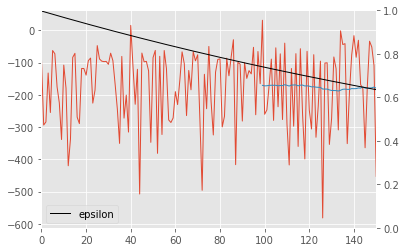

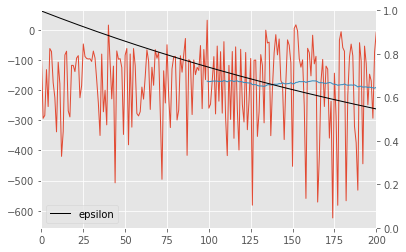

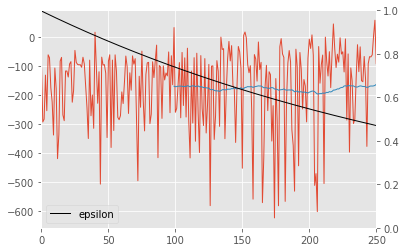

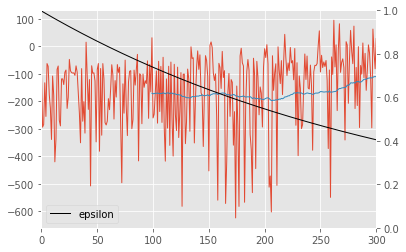

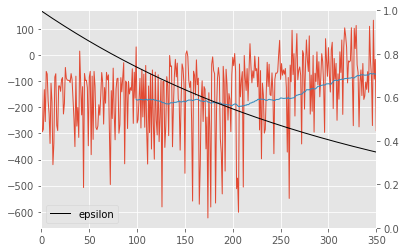

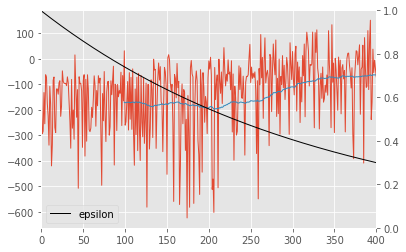

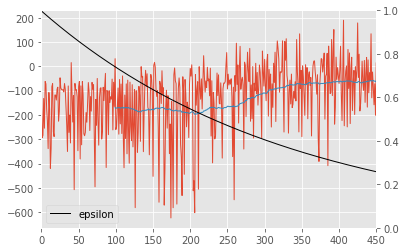

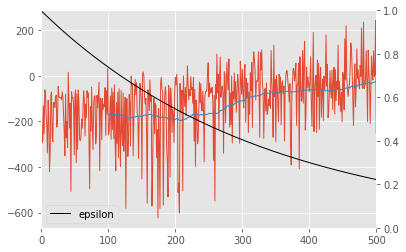

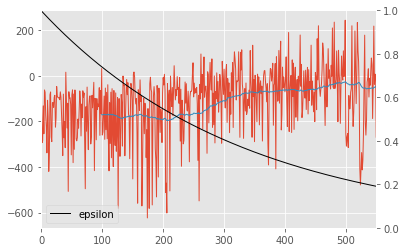

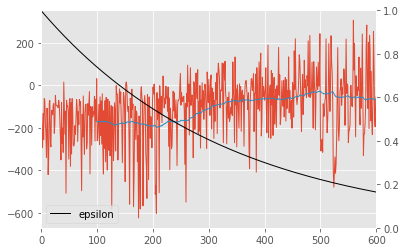

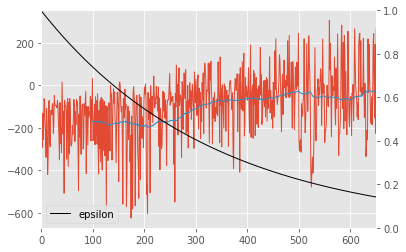

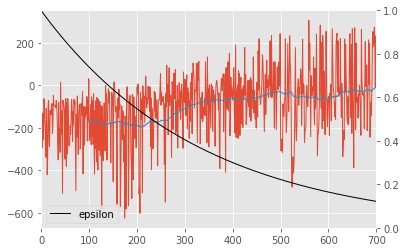

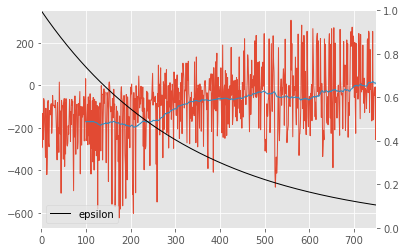

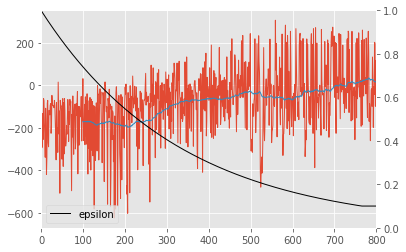

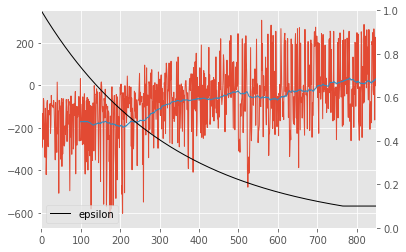

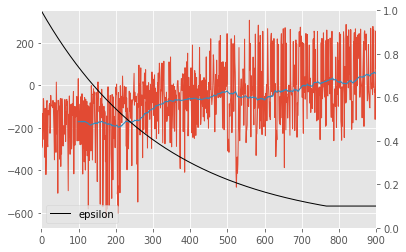

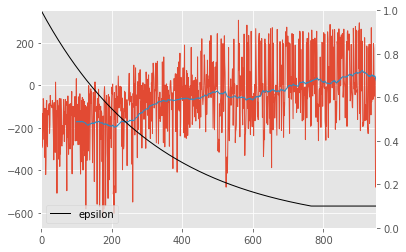

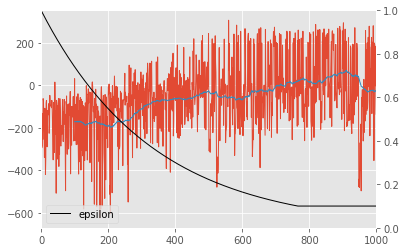

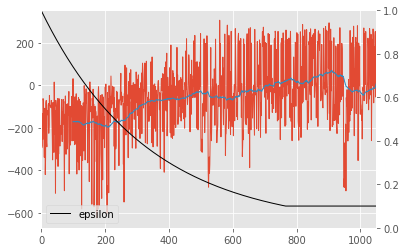

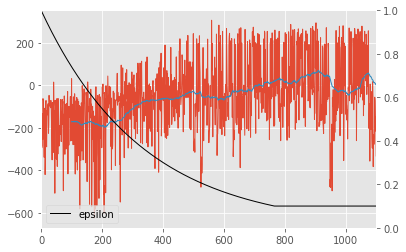

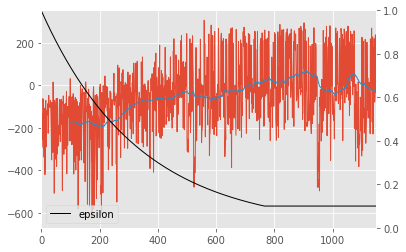

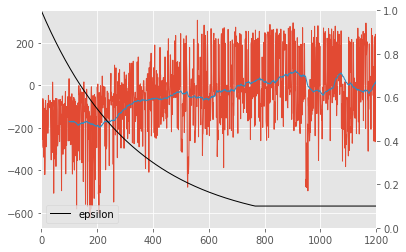

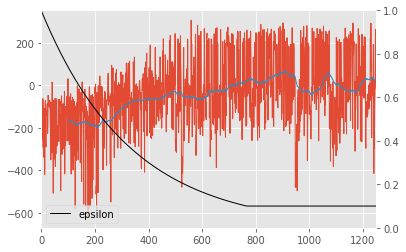

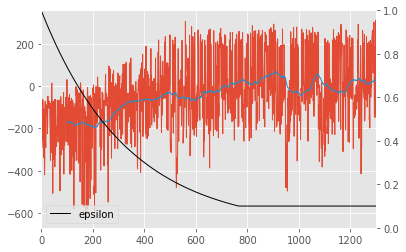

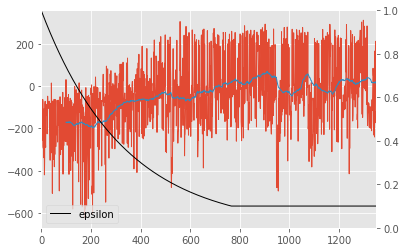

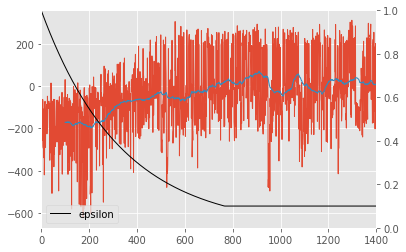

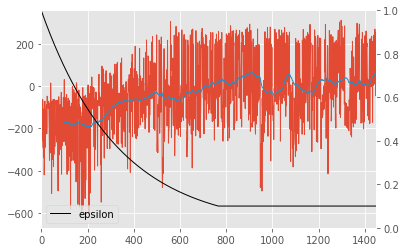

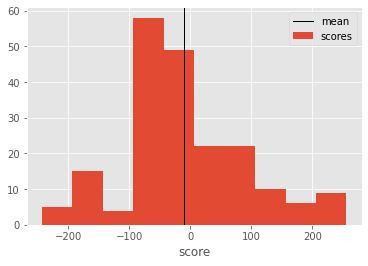

In [9]:
agent1 = NeuralQLearningAgent(env, replay_memory=False, double_q=False, freezing=False)
rewards1 = train_test_agent(env, agent1)

minutes elapsed 27.996905692418416
mean score 166.8652278567721


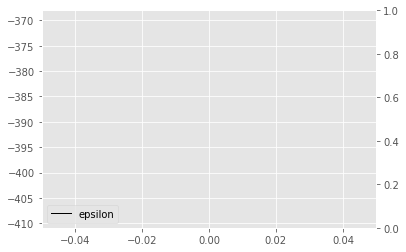

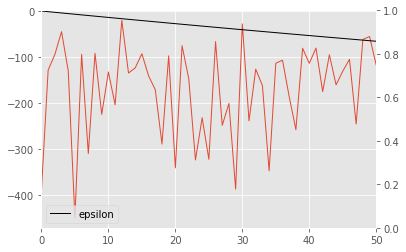

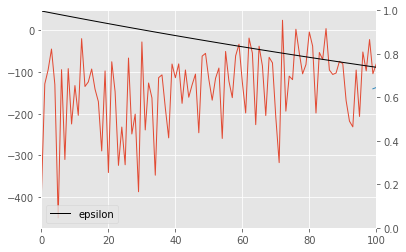

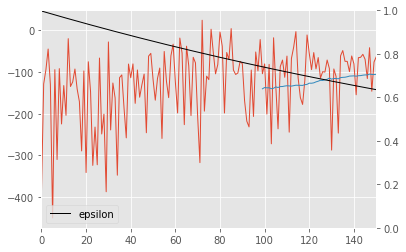

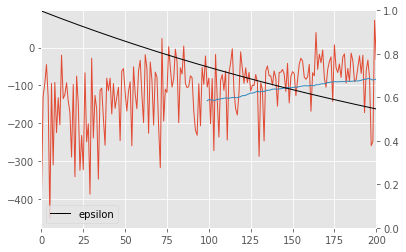

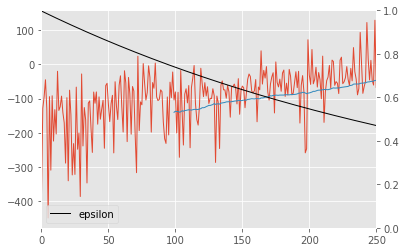

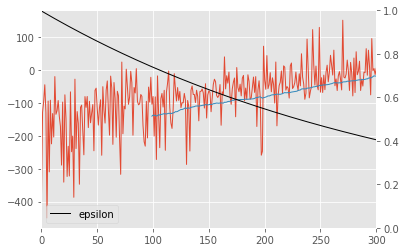

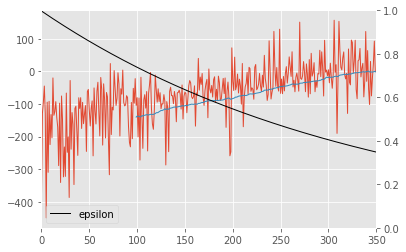

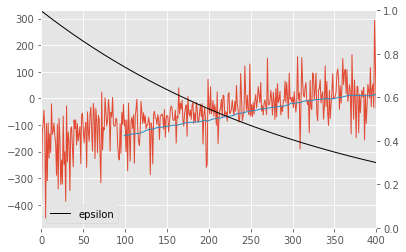

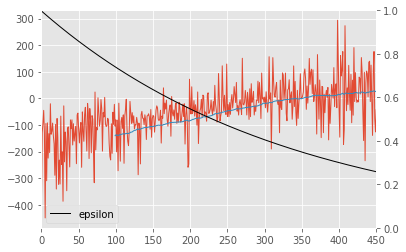

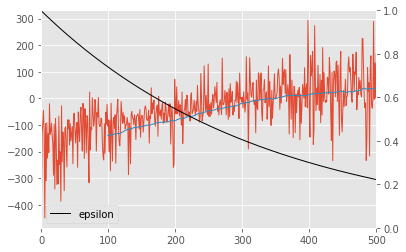

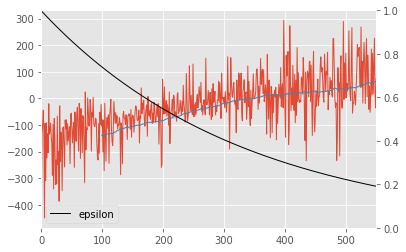

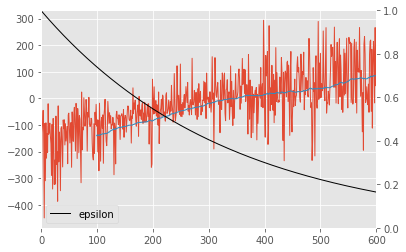

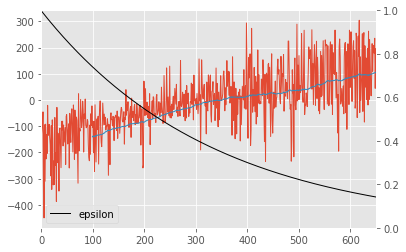

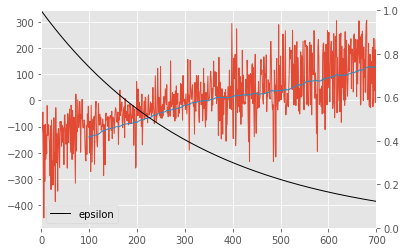

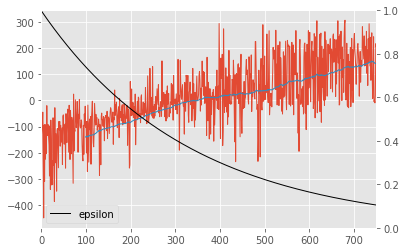

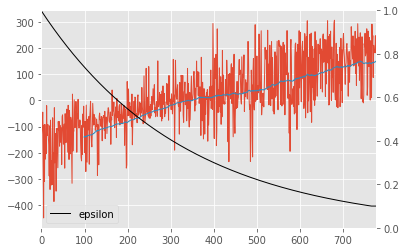

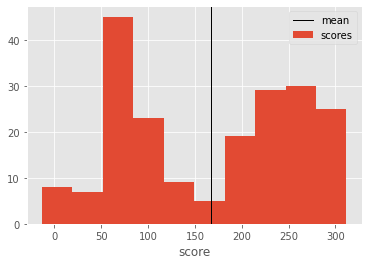

In [10]:
agent2 = NeuralQLearningAgent(env, replay_memory=True, double_q=False, freezing=False)
rewards2 = train_test_agent(env, agent2)

minutes elapsed 21.64520813624064
mean score 255.47038845219768


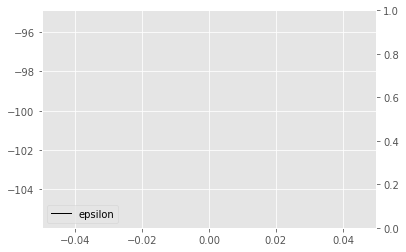

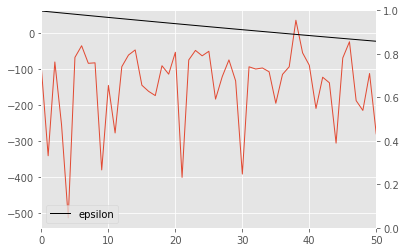

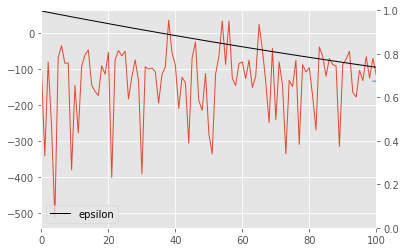

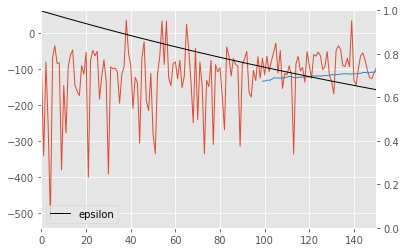

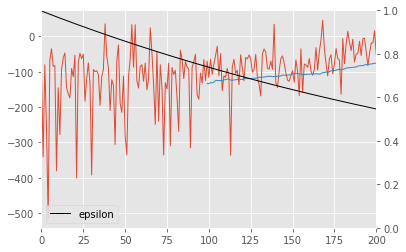

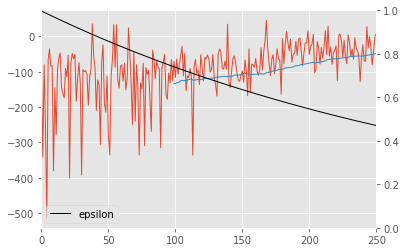

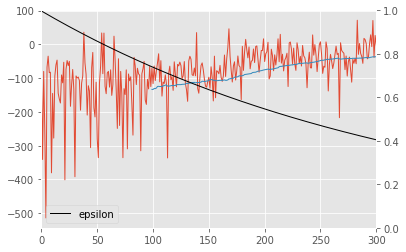

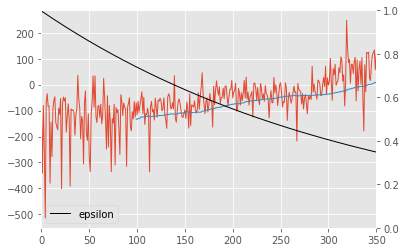

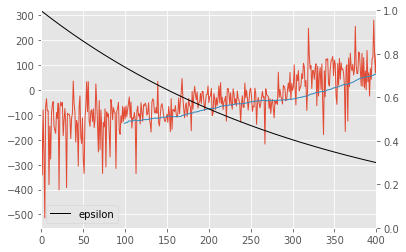

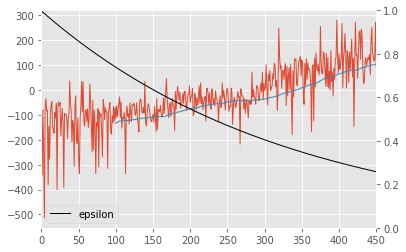

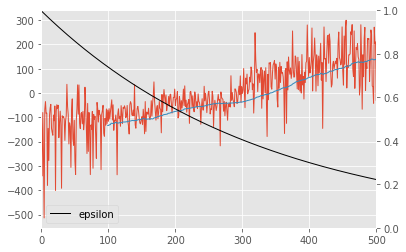

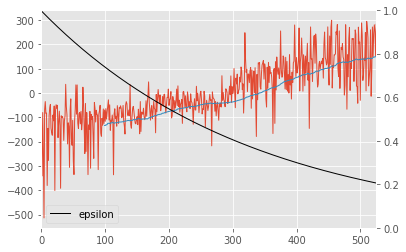

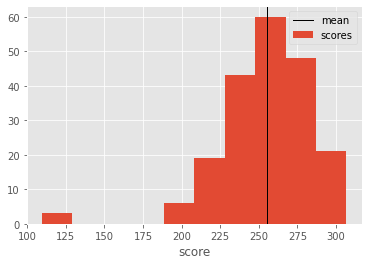

In [11]:
agent3 = NeuralQLearningAgent(env, replay_memory=True, double_q=False, freezing=True)
rewards3 = train_test_agent(env, agent3)

minutes elapsed 21.185102991263072
mean score 217.52581581335835


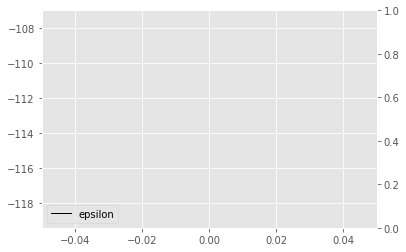

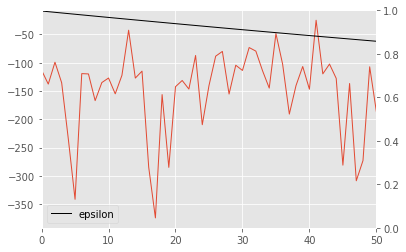

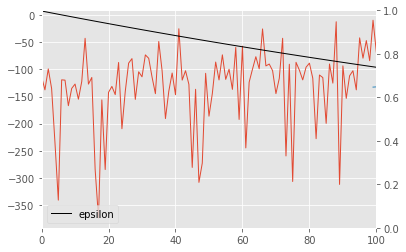

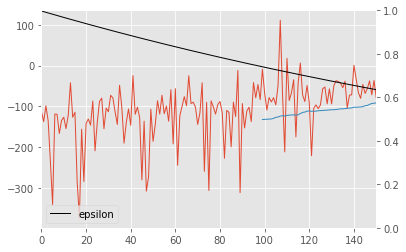

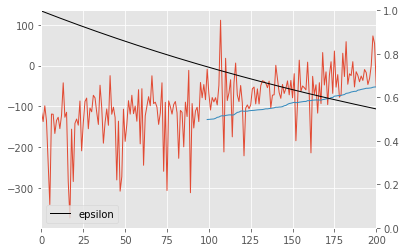

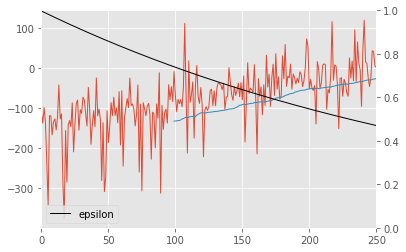

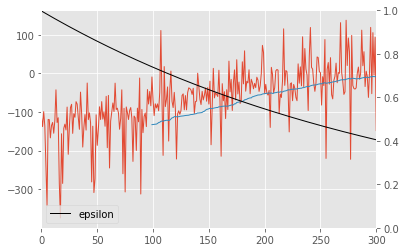

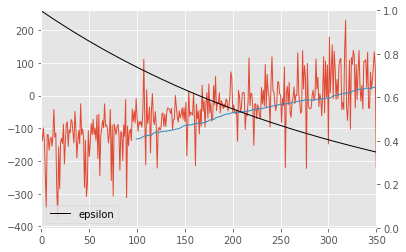

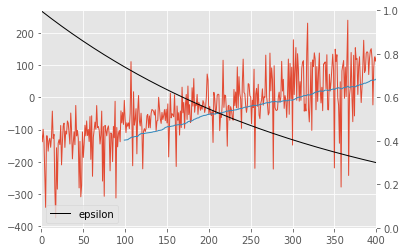

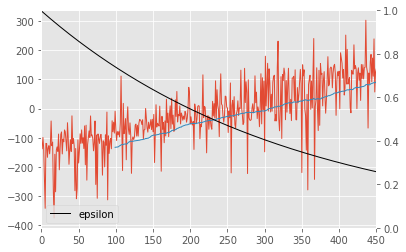

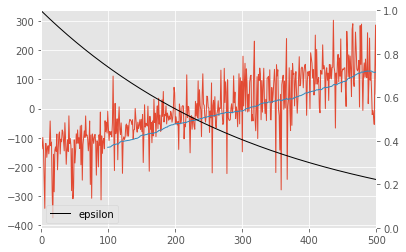

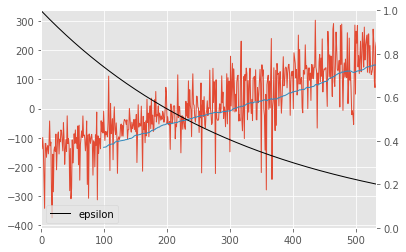

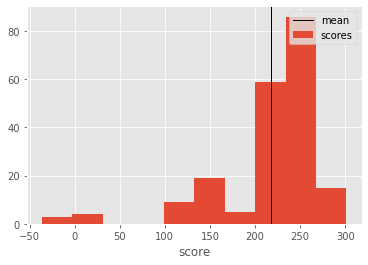

In [8]:
agent4 = NeuralQLearningAgent(env, replay_memory=True, double_q=True, freezing=True)
rewards4 = train_test_agent(env, agent4)

In [156]:
print(agent1.Q_policy)

QModel(
  (model): Sequential(
    (Linear1): Linear(in_features=8, out_features=128, bias=True)
    (Activation1): ReLU()
    (Linear2): Linear(in_features=128, out_features=128, bias=True)
    (Activation2): ReLU()
    (Linear3): Linear(in_features=128, out_features=4, bias=True)
  )
)
